In [1]:
%gui wx
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from mayavi import mlab
import seaborn as sns
from vtk_rw import read_vtk, write_vtk
import operator

In [3]:
def make_cluster_cmap(c):
    cmap = np.asarray(sns.color_palette('cubehelix', c-1))
    cmap = np.concatenate((np.array([[0.4,0.4,0.4]]), cmap), axis=0)
    cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

In [4]:
def make_cont_cmap(c):
    cmap = np.asarray(sns.cubehelix_palette(c-1, start=.5, rot=-.75, reverse=True))
    #cmap = np.asarray(sns.color_palette('Reds_r', c-1))
    cmap = np.concatenate((np.array([[0.4,0.4,0.4]]), cmap), axis=0)
    cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

In [5]:
def chebapprox(profiles, degree):
    profiles=np.array(profiles)
    cheb_coeffs=np.zeros((profiles.shape[0],degree+1))
    cheb_polynoms=np.zeros((profiles.shape[0],profiles.shape[1]))
    for c in range(profiles.shape[0]):
        x=np.array(range(profiles.shape[1]))
        y=profiles[c]
        cheb_coeffs[c]=np.polynomial.chebyshev.chebfit(x, y, degree)
        cheb_polynoms[c]=np.polynomial.chebyshev.chebval(x, cheb_coeffs[c])
    return cheb_coeffs, cheb_polynoms

### load data

In [6]:
mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d.vtk'
full_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/masks/rh_tsnr_full.npy'
min_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/masks/rh_tsnr_min.npy'

In [7]:
v,f,d = read_vtk(mesh_file)

In [8]:
tsnr_full = np.load(full_file)
tsnr_min = np.load(min_file)

In [12]:
hemi='rh'
embed=10
k=10
smooth='smooth_3'
masktype='02_4'
pal, pal_255 = make_cluster_cmap(k+1)
pal_cont, pal_cont_255 = make_cont_cmap(k+1)

mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_%s_d.vtk'%hemi
mask_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/masks/%s_mask.1D.roi'%hemi
embed_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/%s/mask_%s/%s_embed_%s.npy'%(smooth, masktype, hemi, str(embed))
kmeans_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/%s/mask_%s/%s_embed_%s_kmeans_%s.npy'%(smooth, masktype, hemi, str(embed), str(k))
t1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/avg_%s_profiles.npy'%(hemi)

#var_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_var.csv'%(str(n_components_kmeans),smooth, sub, hemi)
#t_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_avg_t.csv'%(str(n_components_kmeans),smooth, sub, hemi)
#p_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_avg_p.csv'%(str(n_components_kmeans),smooth, sub, hemi)
#fig_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_violins.svg'%(str(n_components_kmeans),smooth, sub, hemi)

In [13]:
v,f,d = read_vtk(mesh_file)
x=v[:,0]
y=v[:,1]
z=v[:,2]
triangles=f


mask = np.loadtxt(mask_file)[:,0]
embed=np.load(embed_file)
clust=np.load(kmeans_file)
t1=np.load(t1_file)

### plot cluster / embedding

In [14]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(x,y,z,triangles,scalars=clust, colormap='RdBu')
lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
img.module_manager.scalar_lut_manager.lut.table = pal_255
mlab.draw()
mlab.show()

/usr/lib/python2.7/dist-packages/traits/has_traits.py:1928: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  setattr( self, name, value )


### Get T1 values in all clusters

In [15]:
# make a list of dictionaries for each cluster k0, k1, ...(0=mask to max kmeans) 
t1_clust={}
for c in range(int(clust.max()+1)):
    t1_clust['k'+str(c)]=[]

# write all t1 profiles in one cluster into the list of its dictionary
for i in range(len(t1)):
    kn=int(clust[i])
    t1_clust['k'+str(kn)].append(t1[i])
    
# make other dictionaries with 3 to 7 intracortical profiles and averages, thresholded  1400 to 2500 mean
t1_clust_37={}
t1_clust_37_avg={}
t1_clust_37_coeff_0={}
t1_clust_37_coeff_1={}
t1_clust_37_coeff_2={}
t1_clust_37_coeff_3={}
for c in range(int(clust.max()+1)):
    t1_clust_37['k'+str(c)]=[pro[3:8] for pro in t1_clust['k'+str(c)]
                            if np.mean(pro[3:8]) < 2500
                            and np.mean(pro[3:8]) > 1400]
    t1_clust_37_avg['k'+str(c)]=[np.mean(pro_37) for pro_37 in t1_clust_37['k'+str(c)]]
    
    cheb_coeffs, cheb_polynoms = chebapprox(t1_clust_37['k'+str(c)], 10)
    
    t1_clust_37_coeff_0['k'+str(c)]=[cheb_coeffs[j][0] for j in range(len(t1_clust_37['k'+str(c)]))]
    t1_clust_37_coeff_1['k'+str(c)]=[cheb_coeffs[j][1] for j in range(len(t1_clust_37['k'+str(c)]))]
    t1_clust_37_coeff_2['k'+str(c)]=[cheb_coeffs[j][2] for j in range(len(t1_clust_37['k'+str(c)]))]
    t1_clust_37_coeff_3['k'+str(c)]=[cheb_coeffs[j][3] for j in range(len(t1_clust_37['k'+str(c)]))]


/home/raid3/huntenburg/workspace/try_openblas/local/lib/python2.7/site-packages/numpy/polynomial/chebyshev.py:1761: RankWarning: The fit may be poorly conditioned
  warnings.warn(msg, pu.RankWarning)


### Plot resorted clusters and T1 distributions

In [16]:
T = t1_clust_37_avg

In [17]:
means = {}
for c in range(int(clust.max())):
    means['k'+str(c+1)] = np.mean(T['k'+str(c+1)])
sorted_means = sorted(means.items(), key=operator.itemgetter(1))
sorted_pal = [pal[int(sorted_means[p][0][1:])] for p in range(len(sorted_means))] 
sorted_clust = np.zeros_like(clust)
for p in range(len(sorted_means)):
    kc = int(sorted_means[p][0][1:])
    sorted_clust[np.where(clust==kc)]=(p+1)

plot_list=[]
cluster_list=[]
for m in range(len(sorted_means)):
    plot_list+=T[sorted_means[m][0]]
    cluster_list+=len(T[sorted_means[m][0]])*[sorted_means[m][0]]
    
plot_df=pd.DataFrame(columns=['t1', 'cluster'])
plot_df['t1']=plot_list
plot_df['cluster']=cluster_list

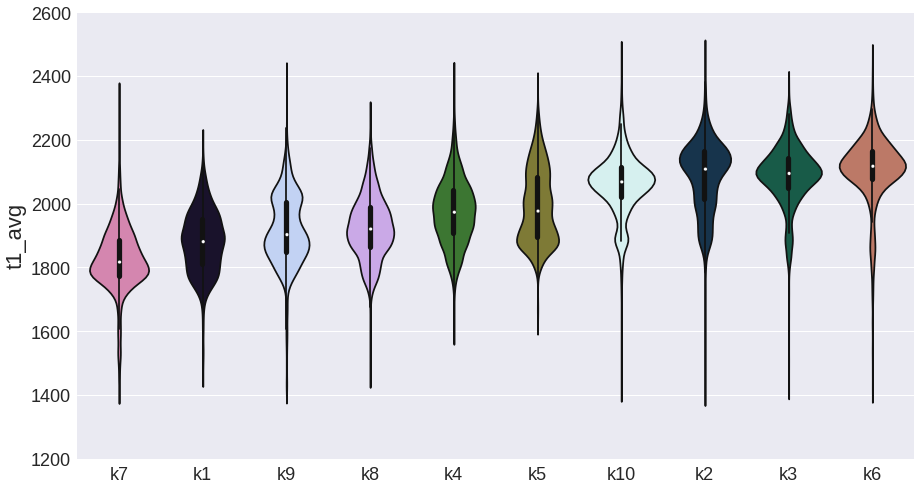

In [21]:
sns.set_context('notebook', font_scale=1.8)
fig = plt.figure(figsize=(15,8))
sns.violinplot(x='cluster', y='t1',data=plot_df, palette=sorted_pal, inner='box', saturation=1)
#sns.violinplot(x='cluster', y='t1',data=plot_df, palette=pal_cont[1:], inner='box', saturation=1)
sns.axlabel('','t1_avg', fontsize=22)
#savefig(fig_file)

In [26]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(x,y,z,triangles,scalars=sorted_clust, colormap='RdBu')
#img = mlab.triangular_mesh(x,y,z,triangles,scalars=clust, colormap='RdBu')
lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
img.module_manager.scalar_lut_manager.lut.table = pal_cont_255
#img.module_manager.scalar_lut_manager.lut.table = pal_255
mlab.draw()
mlab.show()

### Compare variance of kmeans cluster vs all other clusters and mean between all clusters

In [156]:
levene_array=np.zeros((6,int(clust.max())))
col=[]
sigk=[]
for c1 in range(int(clust.max())):
    a=T['k'+str(c1+1)]
    b=[]
    for c2 in range(int(clust.max())):
        if (c2+1) != (c1+1):
            b+=T['k'+str(c2+1)]
    W,p=stats.levene(a, b)
    col.append(int(c1+1))
    levene_array[0,c1]=W
    levene_array[1,c1]=p
    levene_array[2,c1]=np.var(a)
    levene_array[3,c1]=np.var(b)
    if p <(0.05/int(clust.max())):
        levene_array[4,c1]=True
    else:
        levene_array[4,c1]=False
    
    if np.var(a)<np.var(b):
        levene_array[5,c1]=True
    else:
        levene_array[5,c1]=False
        
    if (levene_array[4,c1]==True) and (levene_array[5,c1]==True):
        sigk.append(c1+1)

levene_df=pd.DataFrame(levene_array, columns=col, index=['W', 'p', 'var k', 'var other', 'p<0.05/k', 'var decrease'])
#levene_df.to_csv(var_file)


t_array=np.zeros((int(clust.max()),int(clust.max())))
p_array=np.zeros((int(clust.max()),int(clust.max())))
col2=[]
for c1 in range(int(clust.max())):
    for c2 in range(int(clust.max())):
        if c2>=c1:
            a=T['k'+str(c1+1)]
            b=T['k'+str(c2+1)]
            t,p=stats.ttest_ind(a, b)
            t_array[c1][c2]=t
            p_array[c1][c2]=p
    col2.append(c1+1)
t_df=pd.DataFrame(t_array, columns=col2, index=col2)
p_df=pd.DataFrame(p_array, columns=col2, index=col2)

#t_df.to_csv(t_file)
#p_df.to_csv(p_file)

### Plot  Levene's statistics and T statistics

Variance comparison

In [160]:
pd.options.display.float_format = '{:,.2e}'.format
levene_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
W,3.26e+03,1.18e+03,1.05e+03,2.63e+02,2.44e+03,2.93e+03,2.31e+02,1.18e+03,4.66e+02,1.48e+03,6.64e+02,1.48e+03,3.00e+03,5.05e+00,2.57e+02,1.24e+03,2.02e+02
p,0.00e+00,5.27e-257,3.04e-228,4.50e-59,0.00e+00,0.00e+00,5.32e-52,1.71e-255,4.72e-103,4.70e-321,1.25e-145,1.38e-320,0.00e+00,2.47e-02,8.54e-58,5.33e-269,1.11e-45
var k,6.05e+03,1.02e+04,9.71e+03,3.46e+04,5.77e+03,6.25e+03,1.33e+04,8.48e+03,1.19e+04,6.90e+03,8.95e+03,7.60e+03,3.91e+03,1.73e+04,1.18e+04,7.60e+03,1.56e+04
var other,1.95e+04,1.99e+04,2.03e+04,1.84e+04,2.05e+04,1.98e+04,1.94e+04,2.02e+04,1.98e+04,1.82e+04,1.93e+04,1.96e+04,2.00e+04,1.98e+04,2.00e+04,2.04e+04,1.98e+04
p<0.05/k,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,0.00e+00,1.00e+00,1.00e+00,1.00e+00
var decrease,1.00e+00,1.00e+00,1.00e+00,0.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00


In [202]:
pd.options.display.float_format = '{:,.0f}'.format
levene_df.tail(2)

In [162]:
sig=np.zeros_like(clust)
for i in sigk: 
    sig[clust == i] = i

In [163]:
sigk

[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17]

In [164]:
allcort=np.where(clust!=0)[0].shape[0]
sigcort=np.where(sig!=0)[0].shape[0]
sigpart=sigcort/allcort
print float(sigpart)

0.86933900044


In [165]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(x,y,z,triangles,scalars=sig, colormap='Set2')
lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
img.module_manager.scalar_lut_manager.lut.table = pal_255
mlab.draw()
mlab.show()

T test (T values, p values)

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
t_df

In [ ]:
pd.options.display.float_format = '{:,.2e}'.format
p_df